# **Image Classification of the German Traffic Signs Dataset with Convolutional Neural Networks in TensorFlow**
(Link: http://benchmark.ini.rub.de/)

---

## Step 1: Dataset Exploration

Visualizing the German Traffic Signs Dataset. 

The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [39]:
# Load pickled data and import dependencies
import pickle
import matplotlib.pyplot as plt
from skimage import exposure
%matplotlib inline
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import os
import scipy.ndimage
from matplotlib.gridspec import GridSpec


def get_model_dir():
    model_dir = '{}/{}'.format(os.getcwd(),'model_dir')
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    return model_dir
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

filepath = '/Users/matthewzhou/Desktop/Zhou_Traffic_Signs'
training_file = filepath + '/train.p'
testing_file = filepath + '/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
train['features'] = rgb2gray(train['features'])
test['features'] = rgb2gray(test['features'])

mean = np.mean(train['features'])
print(mean)
mean = np.mean(test['features'])
print(mean)

mean = np.mean(train['features'])
train['features'] /= mean
mean = np.mean(test['features'])
test['features'] /= mean

train_dataset = train['features']
train_labels = train['labels']
test_dataset = test['features']
test_labels = test['labels']

81.8998874369
81.2767774761


In [42]:
train_dataset = np.array(train_dataset)
train_labels = np.array(train_labels)

inputs_per_class = np.bincount(train_labels)
max_inputs = np.max(inputs_per_class)

print('Preprocessing data...')
# Generate additional data for underrepresented classes
print('Generating additional data...')
angles = [-5, 5, -10, 10, -15, 15, -20, 20]

for i in range(len(inputs_per_class)):
    input_ratio = min(int(max_inputs / inputs_per_class[i]) - 1, len(angles) - 1)

    if input_ratio <= 1:
        continue

    new_features = []
    new_labels = []
    mask = np.where(train_labels == i)

    for j in range(input_ratio):
        for feature in train_dataset[mask]:
            new_features.append(scipy.ndimage.rotate(feature, angles[j], reshape=False))
            new_labels.append(i)

    train_dataset = np.append(train_dataset, new_features, axis=0)
    train_labels = np.append(train_labels, new_labels, axis=0)


Preprocessing data...
Generating additional data...


After the pre-processing, let's split the data into training and testing sets. Simply indexing subsets of the dataset skews the data since the dataset is not randomly shuffled -- a good resource is to use sklearn's train_test_split function to randomly split into 80% training data and 20% validation data -- 62,493 images and 12,630 validation images.

In [43]:
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train_dataset, train_labels, test_size = 0.2)

In [44]:
num_channels = 1
image_size = 32
num_labels = 43

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (62493, 32, 32, 1) (62493, 43)
Validation set (15624, 32, 32, 1) (15624, 43)
Test set (12630, 32, 32, 1) (12630, 43)


In [45]:
### To start off let's do a basic data summary.
import numpy as np
# TODO: number of training examples
n_train = len(train_dataset)

# TODO: number of testing examples
n_test = len(test_dataset)

# TODO: what's the shape of an image?
image_shape = train_dataset[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 62493
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43


In [12]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [40]:
def get_label_map(f_name, labels):
    mapper = np.genfromtxt(f_name, delimiter=',', usecols=(1,), dtype=str, skip_header=1)
    crapper = np.vectorize(lambda x : mapper[x])
    return crapper(labels)

def plot_class_frequencies(labels, settype):
    freqs = group(labels)
    plt.figure(figsize=(15,5))
    plt.title(settype + " Set Label Frequencies")
    plt.bar(freqs[:,0], freqs[:,1])
    plt.xlabel('ClassID')
    plt.ylabel('Frequency')
    ind = np.arange(0.5,43.5)
    plt.xticks(ind, get_label_map('signnames.csv', np.unique(labels)),  ha='right', rotation=45)
    plt.show()

def group(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return np.asarray((unique, counts)).T

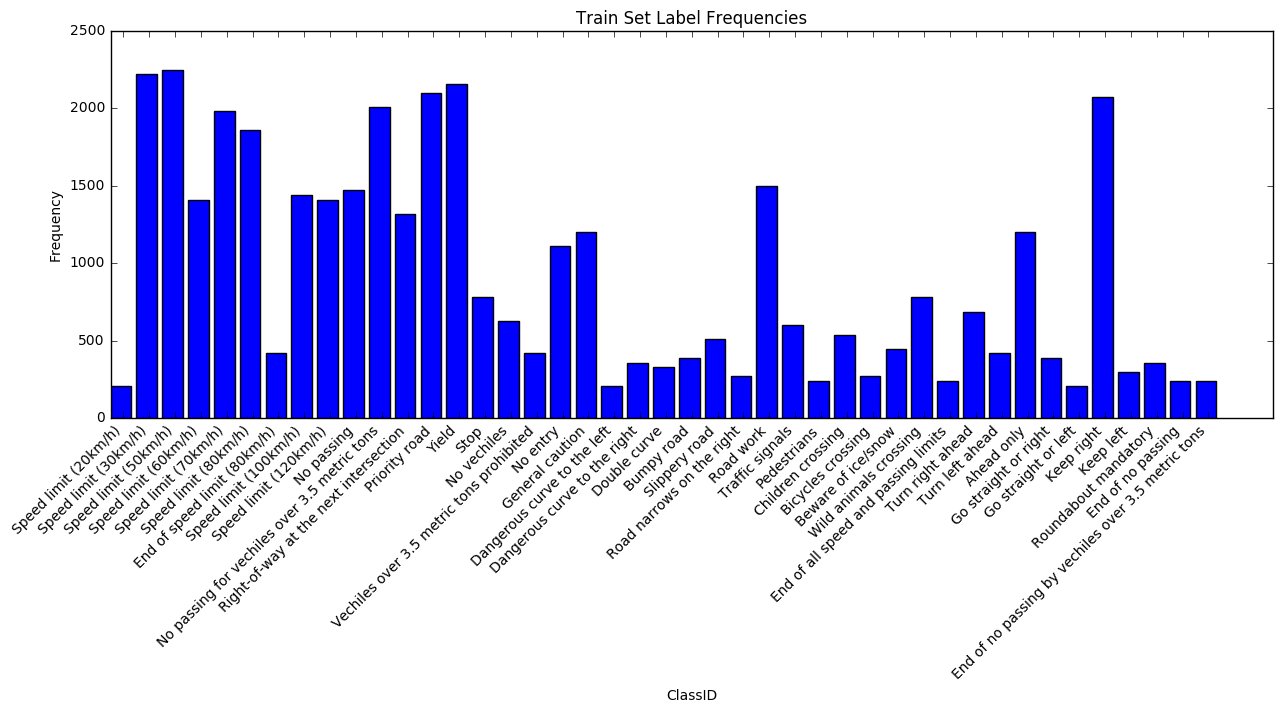

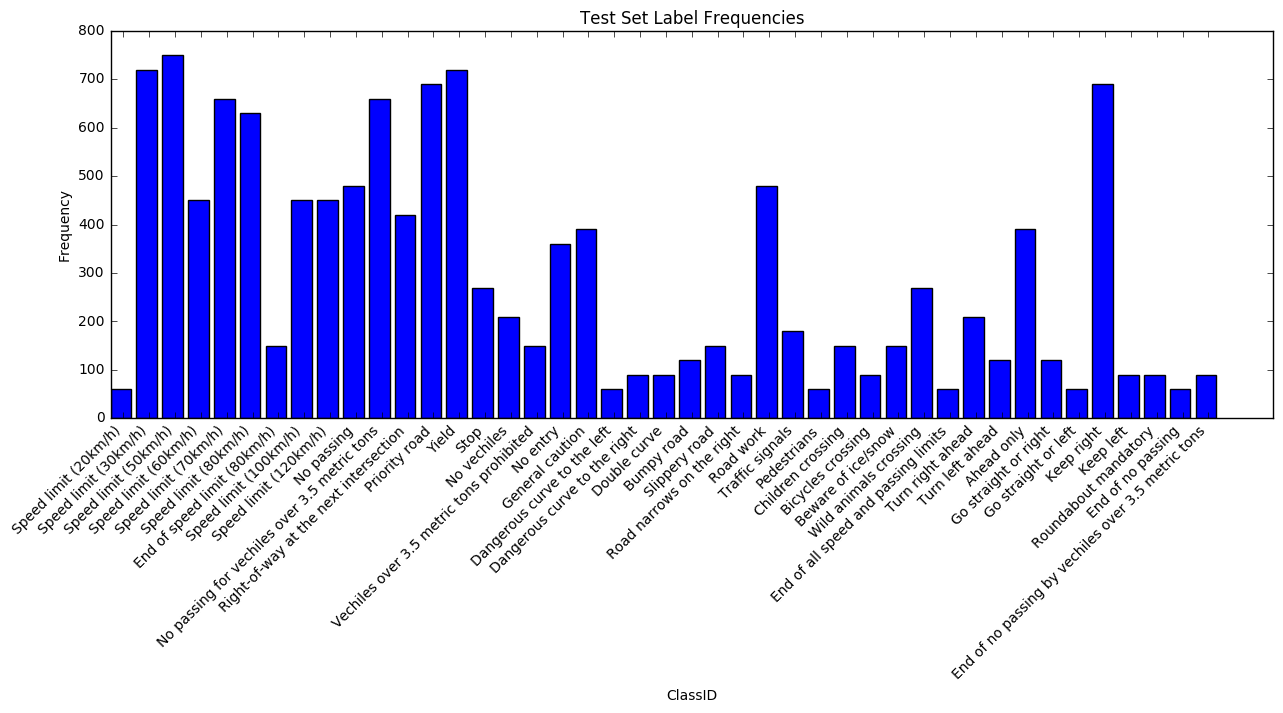

In [41]:
plot_class_frequencies(train_labels, "Train")
plot_class_frequencies(test_labels, "Test")

Examining the distribution of class labels, there is uneven balance between the 43 output classes within the dataset. This could underrepresent certain classes within our predictions -- in order to resolve this, I'll build an image augmentation generator to apply rotations to existing training images to double the amount of training data to 75,123 images. 

After generating these images, I'll normalize the input pixel values by dividing the training image pixels element-wise by the global mean of training data and the test image pixels element-wise by the global mean of testing data. This was done to reduce the scale of variance, allowing the Tensorflow optimizer to test a smaller range of weights to find the optimum. The different means were taken in order to help standardize data more exactly to control for lighting or background image interference. This difference was minimal and the model could realistically work only normalizing by the training mean (train mean = 81.8998874369, test mean = 81.2767774761).

----

## Step 2: Designing and Testing the Model Architecture



In [46]:
#Best output
batch_size = 64
patch_size = 5
depth = 12
num_hidden1 = 64
num_hidden2 = 32
drop_out = 0.5

graph = tf.Graph()


####################################################
"""
The model architecture consists of 6 layers: 

1. Convolution Layer with 12 filters using 5X5 patch size applying a [1,1,1,1] filter using VALID padding
2. Pooling layer using Average Pooling with [1,2,2,1] filter using VALID padding
3. Convolution Layer with 12 filters using 5X5 patch size applying a [1,1,1,1] filter using VALID padding
4. Pooling layer using Average Pooling with [1,2,2,1] filter using VALID padding
5. Fully Connected Layer with 1452 hidden units and 0.5 dropout applied
6. Fully Connected Layer with 64 hidden units and 0.5 dropout and RELU applied
7. Fully Connected Layer with 32 hidden units and 0.5 dropout and RELU applied
8. Fully Connected Layer with 43 output nodes
"""

with graph.as_default():

    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    layer3_weights = tf.Variable(tf.truncated_normal([size3 * size3 * depth, num_hidden1], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
    layer5_weights = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
    def model(data, keep_prob):
        # C1
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
        bias1 = tf.nn.relu(conv1 + layer1_biases)
        # S2
        pool2 = tf.nn.avg_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        # C3
        conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding='VALID')
        bias3 = tf.nn.relu(conv3 + layer2_biases)
        # S4
        pool4 = tf.nn.avg_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        # F5 input 5 x 5
        shape = pool4.get_shape().as_list()
        reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden5 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # F6
        drop5 = tf.nn.dropout(hidden5, keep_prob)
        hidden6 = tf.nn.relu(tf.matmul(hidden5, layer4_weights) + layer4_biases)
        drop6 = tf.nn.dropout(hidden6, keep_prob)
        #F7
        return tf.matmul(drop6, layer5_weights) + layer5_biases
  
  # Training computation.
    #if test == True:
    #    image_predictions = tf.nn.softmax(model(tf_test_images, 1.0))
    #else:
    logits = model(tf_train_dataset,drop_out)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

In [47]:
#Best output
num_steps = 10001

#with tf.Session(graph=graph) as session:
session = tf.InteractiveSession(graph = graph)
with session.as_default():
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    saver = tf.train.Saver()
    model_path = get_model_dir()
    saver.save(session, '{}/the_model'.format(model_path))
    print('model_saved at {}/the_model'.format(model_path))


Initialized
Minibatch loss at step 0: 4.320114
Minibatch accuracy: 4.7%
Validation accuracy: 2.5%
Minibatch loss at step 50: 3.753784
Minibatch accuracy: 6.2%
Validation accuracy: 3.3%
Minibatch loss at step 100: 3.735532
Minibatch accuracy: 3.1%
Validation accuracy: 4.8%
Minibatch loss at step 150: 3.672991
Minibatch accuracy: 6.2%
Validation accuracy: 6.3%
Minibatch loss at step 200: 3.500242
Minibatch accuracy: 6.2%
Validation accuracy: 8.3%
Minibatch loss at step 250: 3.409024
Minibatch accuracy: 14.1%
Validation accuracy: 17.9%
Minibatch loss at step 300: 3.119277
Minibatch accuracy: 12.5%
Validation accuracy: 25.4%
Minibatch loss at step 350: 2.601869
Minibatch accuracy: 34.4%
Validation accuracy: 37.7%
Minibatch loss at step 400: 2.347097
Minibatch accuracy: 34.4%
Validation accuracy: 46.0%
Minibatch loss at step 450: 2.457872
Minibatch accuracy: 28.1%
Validation accuracy: 53.1%
Minibatch loss at step 500: 2.300774
Minibatch accuracy: 31.2%
Validation accuracy: 57.7%
Minibatch l

I first established my Tensorflow model implementing a basic logistic regression classifier to ensure that the overall model worked using a single FC layer perceptron. After the pipeline was smoothed out and the Tensorflow syntax was mastered, I began to add layers in hopes that a deeper network would achieve stronger results than widening layers. Using short epoch lengths of 1001, I began to modify my model architecture using different strategies of down-sampling the input images and using pooling layers to summarize information. With this iterative process, I quickly discovered overfitting in the training/validation results and applied differing levels of dropout to regularize the model. After feeling satisfied with the complexity and prototyping accuracy with respect to the constraints of my local CPU machine, I extended the epoch length in order to benchmark my accuracy on test images and found it to be 91.4%, which I deemed acceptable. 

The model was trained using the Adam optimizer with a learning rate of 0.001 that minimized the mean cross-entropy of the training loss. The model was trained in batch sizes of 64, with 10001 epochs and dropout set at 0.5. The epoch length was set after training the model over 15,001 epochs and examining where the validation accuracy plateaued -- in trial runs, it tended to converge around 10000 epochs at 98% validation accuracy. Given that any further epochs would indicate overfitting to the training data, I chose to limit my training length to the limit of good fit. 

---

## Step 3: Testing the Model on New Images

Using several pictures of traffic signs that I pulled from the internet, I ran test images through my model to produce sample predictions.

Using 'signnames.csv', I was able to map class labels to the one-hot-encoded labels for visualization purposes. 

In [48]:
with open('new_test.p', 'rb') as n_file:
    test_images = pickle.load(n_file)

In [49]:
reshaped_images = rgb2gray(test_images)
mean = np.mean(reshaped_images)
reshaped_images /= mean
reshaped_images = reshaped_images.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)

In [50]:
tf_test_images = tf.constant(reshaped_images)
outputs = tf.nn.softmax(model(tf_test_images, 1.0))
top_k = session.run(tf.nn.top_k(input=outputs.eval(), k=5, sorted=True))

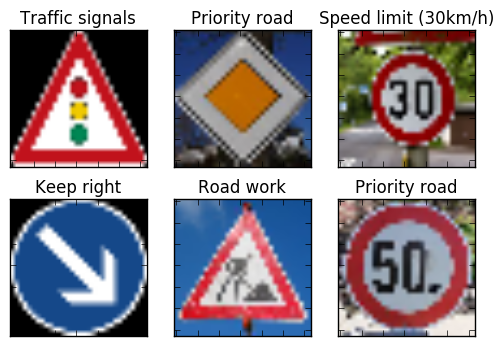

In [51]:
top_labels = []
for labels in top_k.indices :
    top_labels.append(get_label_map('signnames.csv', labels))

_, axs = plt.subplots(2,3)
axs = axs.ravel()
plt.figure(figsize=(2,2));
for i, (test_image, label) in enumerate(zip(test_images, top_labels)):
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].imshow(test_image)
    axs[i].set_title(label[0])
    # plt.title(label[0])
plt.show();

Interfering qualities for the candidate images could be background image interference where the model might pick up background noise as meaningful patterns for traffic signs. Lighting may result in differing probabilities depending on overcast or shadow on the relevant images. Pixel quality may be challenging as well given that these images were downsized from larger pixel values. 

In [52]:
#Visualizing the tf.nn.top_k softmax probability outputs as arrays
top_k

TopKV2(values=array([[  9.77139533e-01,   2.28604209e-02,   5.17193151e-08,
          1.25870991e-09,   2.49413581e-13],
       [  9.47623968e-01,   4.71842997e-02,   2.78755859e-03,
          1.84490334e-03,   3.05712107e-04],
       [  9.64430988e-01,   3.55215333e-02,   2.74458343e-05,
          1.45283811e-05,   5.17850049e-06],
       [  9.74771321e-01,   2.52128765e-02,   1.32708456e-05,
          1.72075124e-06,   7.84520694e-07],
       [  9.99998212e-01,   6.27155714e-07,   6.22474545e-07,
          4.71625583e-07,   1.08014305e-07],
       [  6.22216582e-01,   2.93239564e-01,   5.82624227e-02,
          1.87113713e-02,   4.11617476e-03]], dtype=float32), indices=array([[26, 18, 24, 20,  0],
       [12, 40, 32, 11,  7],
       [ 1,  0,  2,  5,  8],
       [38, 25, 36, 20, 34],
       [25, 29, 31, 26, 20],
       [12,  1,  2,  7, 40]], dtype=int32))

Using the TensorFlow tf.nn.top_k function to extract the top 5 softmax probabilities for each prediction, I was able to get a closer look at how my model is processing each candidate image. 

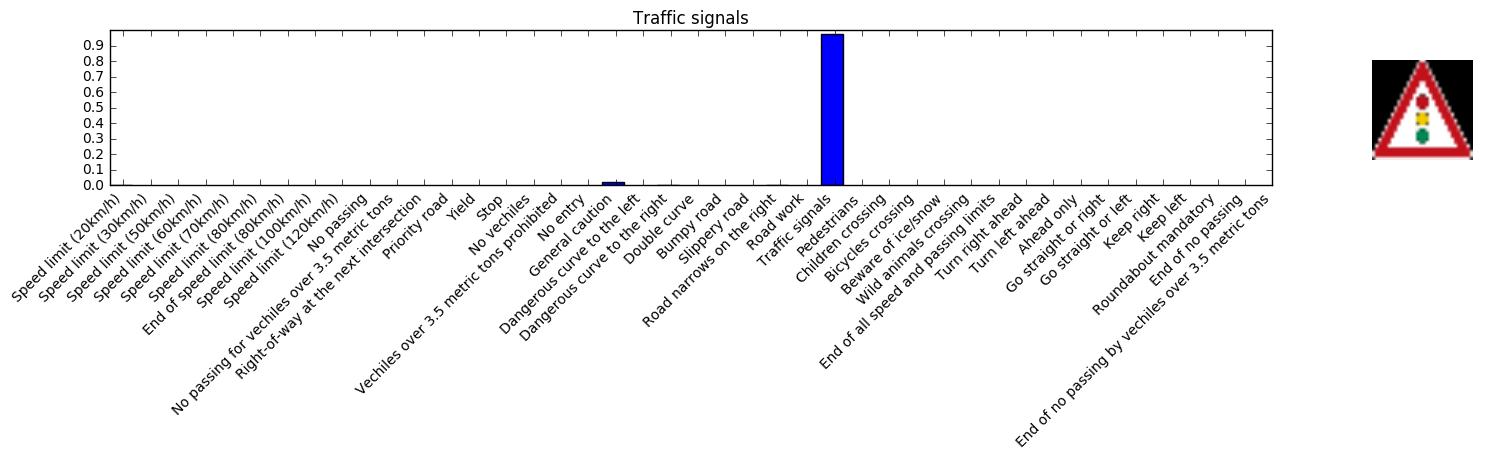

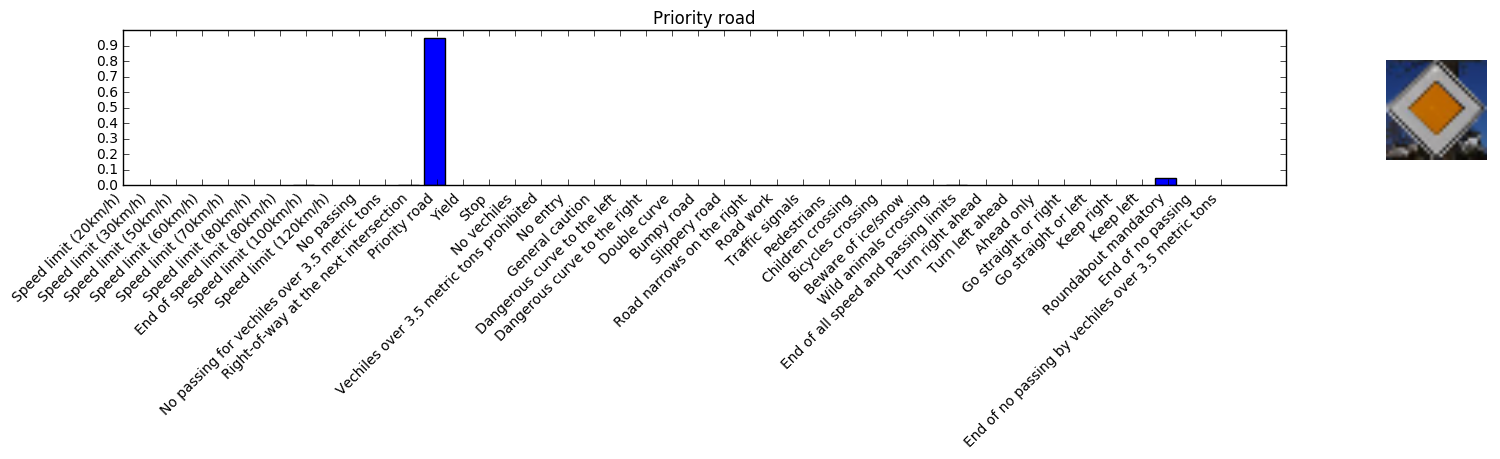

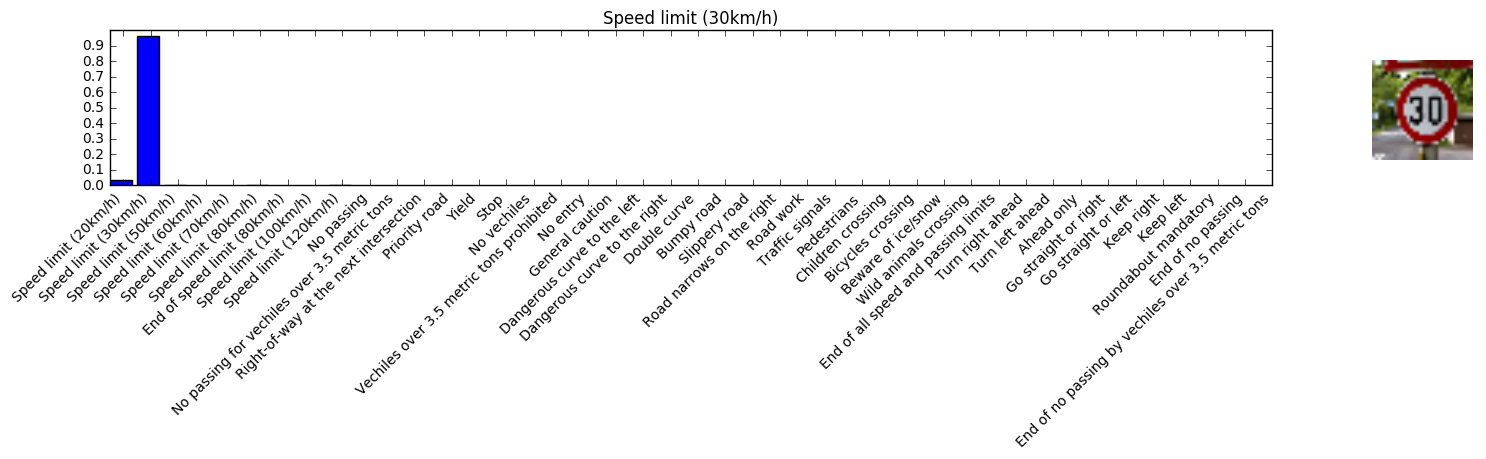

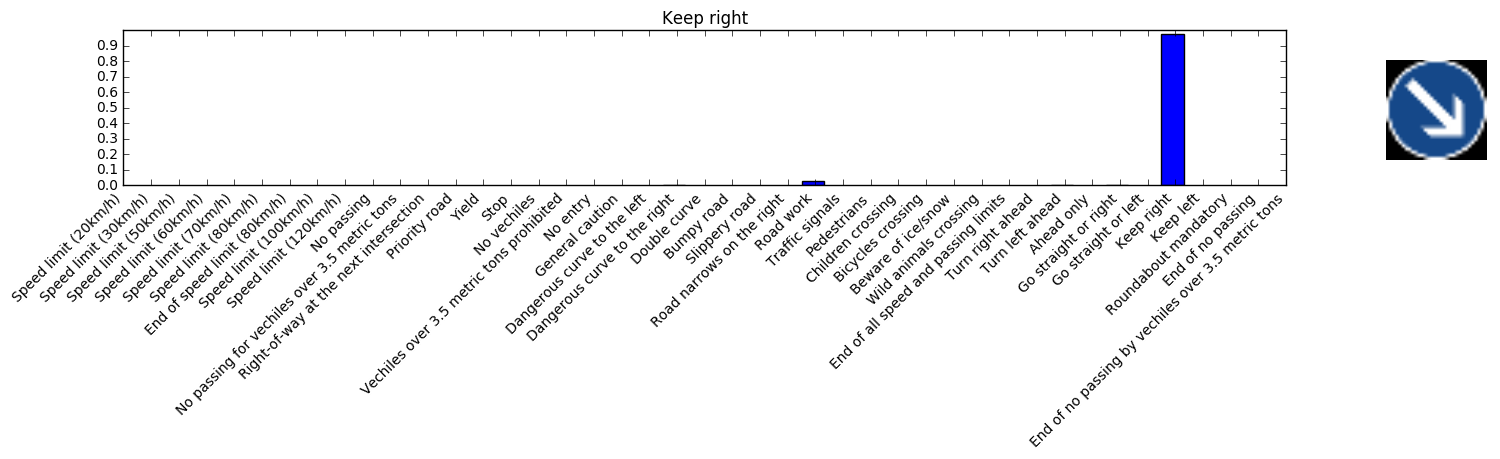

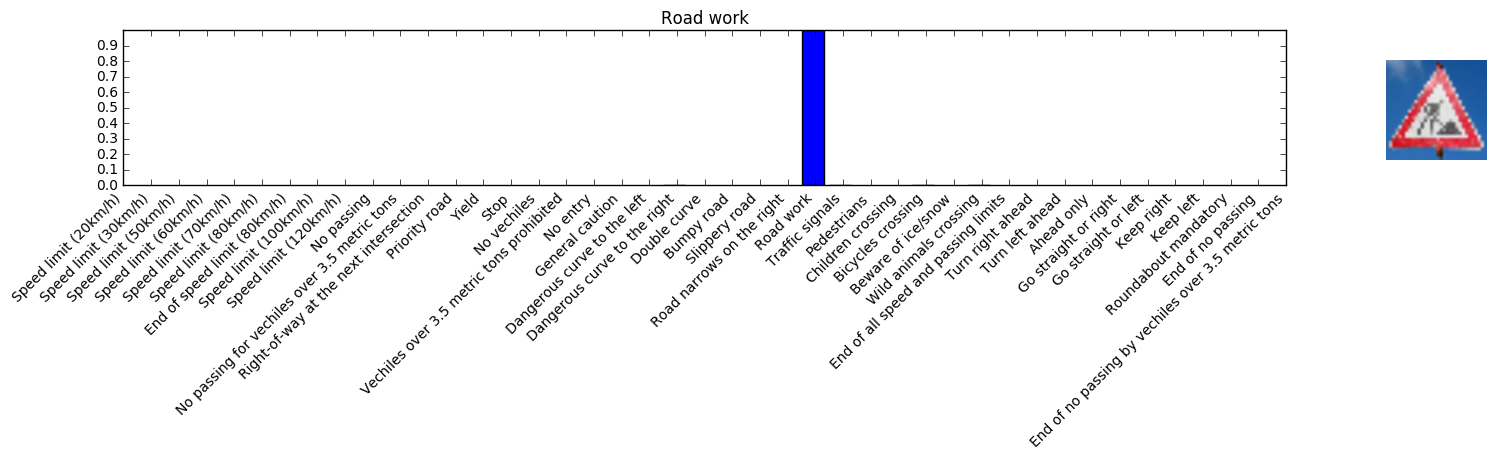

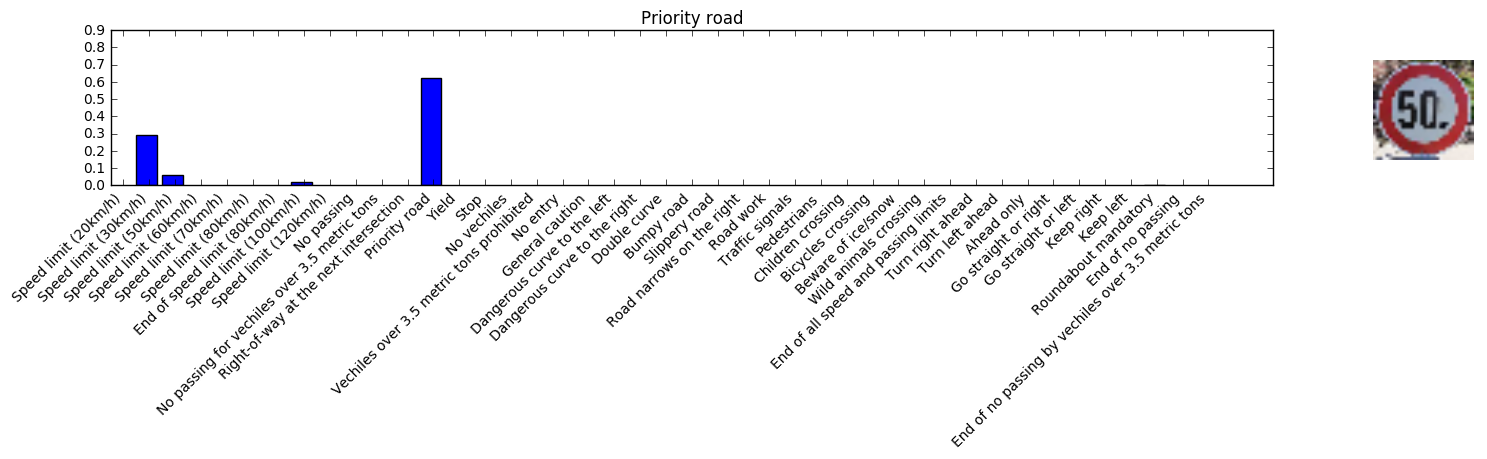

In [53]:
for i, (labels, probs, candidate) in enumerate(zip(top_k.indices, top_k.values, test_images)):
    fig = plt.figure(figsize=(15, 2))
    plt.bar(labels,probs)
    plt.title(top_labels[i][0])
    height = candidate.shape[0]
    plt.xticks(np.arange(0.5, 43.5, 1.0), get_label_map('signnames.csv', np.unique(train['labels'])),  ha='right', rotation=45)
    plt.yticks(np.arange(0.0,1.0,0.1), np.arange(0.0, 1.0, 0.1))
    ax = plt.axes([.75,0.25, 0.5, 0.5], frameon=True)  # Change the numbers in this array to position your image [left, bottom, width, height])
    ax.imshow(candidate)
    ax.axis('off')  # get rid of the ticks and ticklabels
    
plt.show()

Out of the 6 test images used for captured pictures, the model correctly predicted 5/6 images with 83.33% accuracy. The incorrectly classified image was a '50 km/hr' sign that was misclassified as a "Priority Road" sign. Clearly, there requires some fine-tuning but the results are encouraging and support the performance of 91.24% on the test dataset.

The model is reasonably confident in most of the predictions (5 predictions with above 90% certainty). The last prediction is incorrect but the model seems uncertain of its prediction despite the clear image and distinct numbers describing a 50km/hr speed limit sign. The reason behind this is not certain, but it could derive from a skewness away from 50km/hr speed limit signs in the training data that underrepresent the class label. It is encouraging that the incorrect prediction is made with less certainty, indicating that a threshold of confidence might be beneficial in rooting out bad predictions. The correct prediction, "50 km/hr" is included in the top 5 as the third most probable prediction.

**Model Pipeline:**

This Tensorflow model is built with an interactive session -- this means that the model can be trained within a session that does not automatically close, allowing further runs on the same session for further test images. After training a new model, the code will automatically save the model in the directory and it can be pulled up in the future to quickly process new images. Test images can be stored in the test_images folder and pre-processed and re-sized using the process_test_images iPython notebook. Afterwards, the test images can be run through the pipeline created in this notebook to visualize the images, generate predictions, and graph the prediction probabilities. The number of test images able to be processed is not bound by size nor quantity. 